# House Prices Prediction using XGBoost - HTJWORLD

캐글 컴피티션에서 가장 예측력이 좋았던 XGBoost 모델을 사용해 예측을 해보려고 합니다

## Import the library

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline
import warnings; warnings.simplefilter('ignore')

## Load the dataset


In [2]:
train_file_path = "../input/house-prices-advanced-regression-techniques/train.csv"
train = pd.read_csv(train_file_path)
print("Full train dataset shape is {}".format(train.shape))

test_file_path = "../input/house-prices-advanced-regression-techniques/test.csv"
test = pd.read_csv(test_file_path)
# ids = Xtest.pop('Id')

print(train.shape)
print(test.shape)

#train과 test에 두개의 데이터 셋을 저장해둡니다

Full train dataset shape is (1460, 81)
(1460, 81)
(1459, 80)


In [3]:
raw_data= train
#raw_data에 백업 (SalesPrice를 포함하기 때문에 시각화 용이)

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

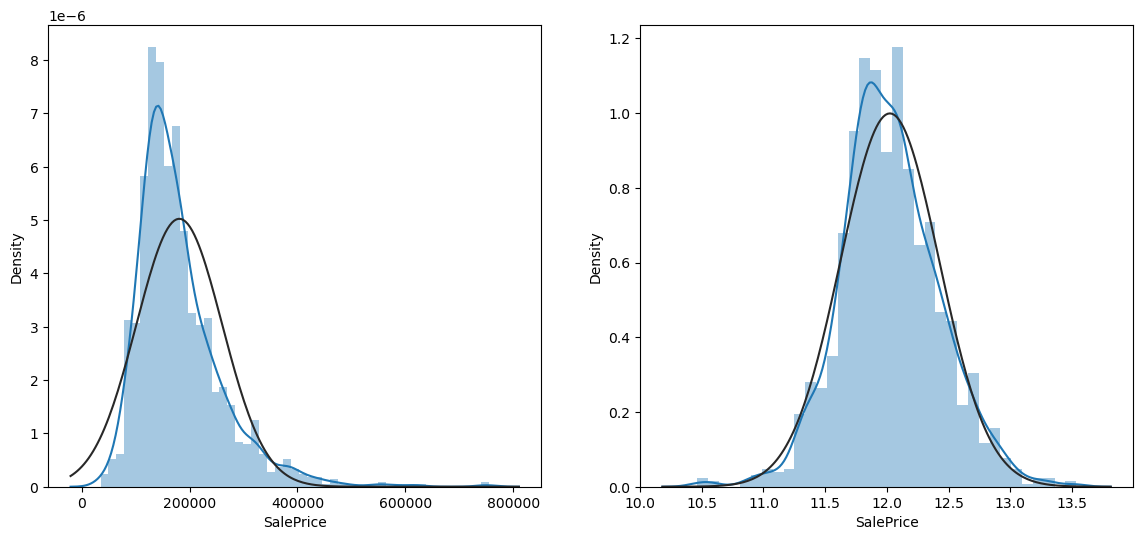

In [4]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.distplot(train['SalePrice'], fit=norm, ax=ax1)
sns.distplot(np.log(train['SalePrice']+1), fit=norm, ax=ax2)
#SalePrice에서 1을 더한 후 로그를 씌운 값들이 훨씬 더 정규분포를 따름을 볼 수 있다.

Data가 rightskewed 돼있음을 확인 가능하다. <br>
이 경우 대표적으로 로그를 취할 수 있다!

<AxesSubplot:>

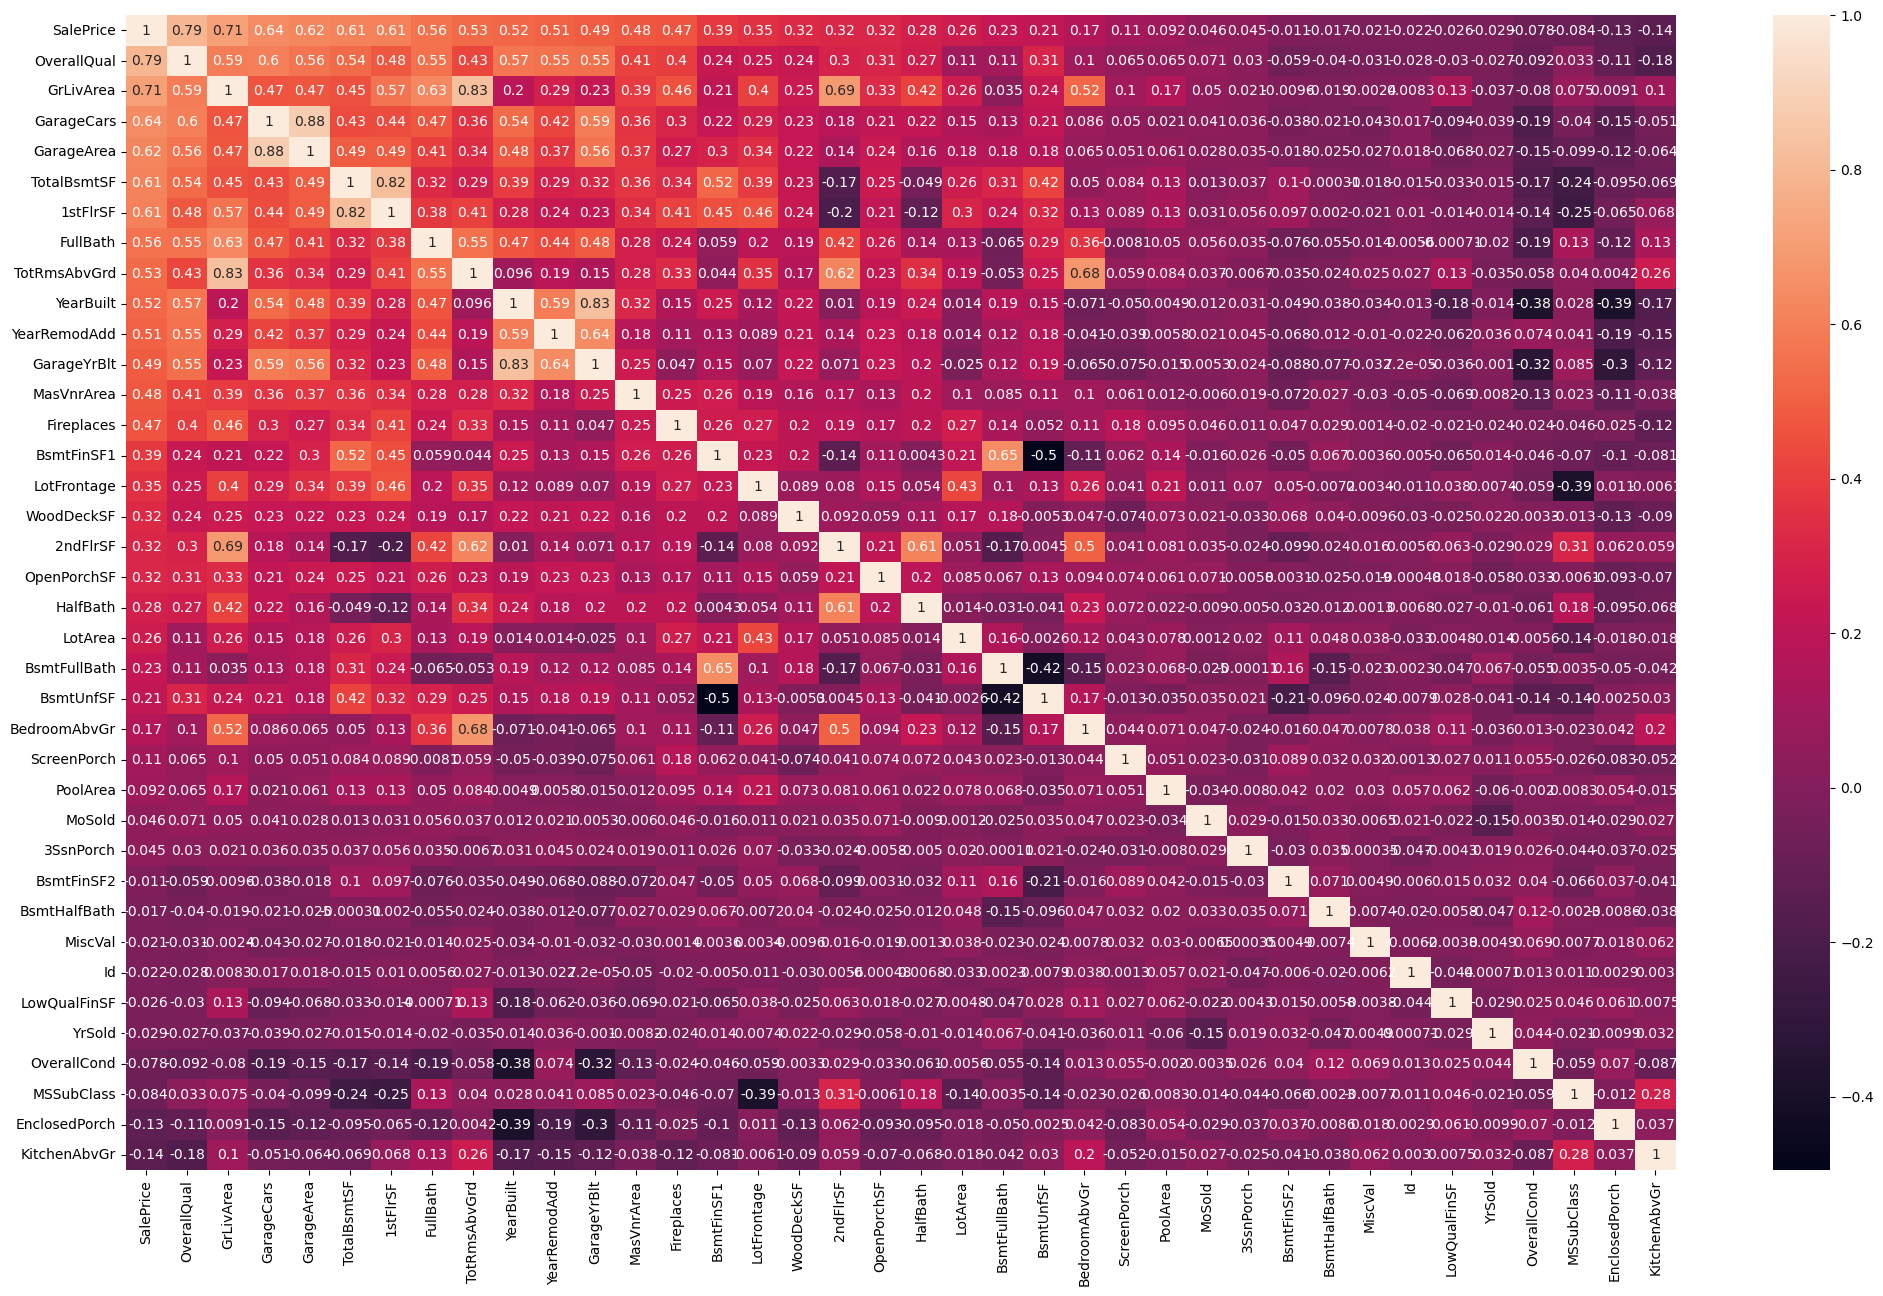

In [5]:
corr=train.corr()
top_corr=train[corr.nlargest(40,'SalePrice')['SalePrice'].index].corr()
figure, ax1 = plt.subplots(nrows=1, ncols=1)
figure.set_size_inches(25,15)
sns.heatmap(top_corr, annot=True, ax=ax1)

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

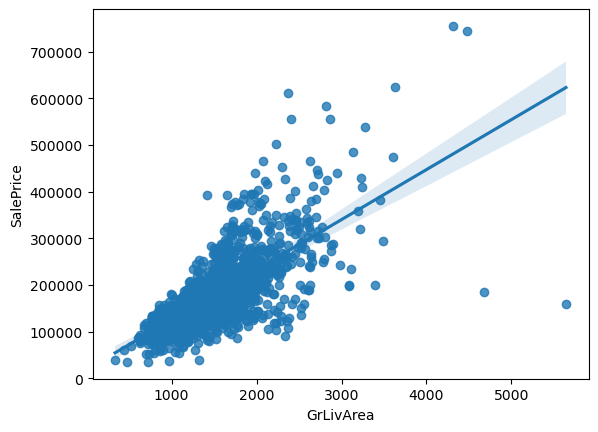

In [6]:
sns.regplot(x=train['GrLivArea'], y=train['SalePrice'])

오른쪽 아래의 이상치 두개 삭제하기

In [7]:
train=train.drop(train[(train['GrLivArea']>4000) & (train['SalePrice']<300000)].index)

In [8]:
print(train.shape)

(1458, 81)


In [9]:
# print(train['SalePrice'].describe())
# plt.figure(figsize=(9, 8))
# sns.distplot(train['SalePrice'], color='b', bins=100, hist_kws={'alpha': 0.4});

In [10]:
Ytrain = train.pop("SalePrice")

print(train.shape)

all_data=pd.concat((train, test), axis=0)

print(all_data.shape)

Ytrain = np.log(Ytrain + 1)

(1458, 80)
(2917, 80)


In [11]:
print(Ytrain.shape)

(1458,)


print(all_data[0:1458]) #이게 Xtrain데이터

print(all_data[1458:]) #이게 Xtest데이터

In [12]:
print(Ytrain.head())

#SalePrice에 로그를 취해 정규분포 모향을 보이도록 해준다. 이를 통해 골고루 분포된 데이터들로 학습을 시켜준다

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64


The data is composed of 81 columns and 1460 entries. We can see all 81 dimensions of our dataset by printing out the first 3 entries using the following code:

In [13]:
dataset_df = all_data

이제 all_data는 백업시켜놓고 dataset_df를 갖고 처리를 해볼 것이다.

In [14]:
dataset_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal


* There are 79 feature columns. Using these features your model has to predict the house sale price indicated by the label column named `SalePrice`.

We will drop the `Id` column as it is not necessary for model training.

We can inspect the types of feature columns using the following code:

In [15]:
dataset_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2917 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2917 non-null   int64  
 1   MSSubClass     2917 non-null   int64  
 2   MSZoning       2913 non-null   object 
 3   LotFrontage    2431 non-null   float64
 4   LotArea        2917 non-null   int64  
 5   Street         2917 non-null   object 
 6   Alley          198 non-null    object 
 7   LotShape       2917 non-null   object 
 8   LandContour    2917 non-null   object 
 9   Utilities      2915 non-null   object 
 10  LotConfig      2917 non-null   object 
 11  LandSlope      2917 non-null   object 
 12  Neighborhood   2917 non-null   object 
 13  Condition1     2917 non-null   object 
 14  Condition2     2917 non-null   object 
 15  BldgType       2917 non-null   object 
 16  HouseStyle     2917 non-null   object 
 17  OverallQual    2917 non-null   int64  
 18  OverallC

In [16]:
cols=list(dataset_df)
for col in list(dataset_df):
    if (dataset_df[col].isnull().sum())==0:
        cols.remove(col)
    else:
        pass
print(len(cols))

34


In [17]:
print(cols)

['MSZoning', 'LotFrontage', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']


## House Price Distribution

Now let us take a look at how the house prices are distributed.

## Numerical data distribution

We will now take a look at how the numerical features are distributed. In order to do this, let us first list all the types of data from our dataset and select only the numerical ones.

In [18]:
list(set(dataset_df.dtypes.tolist()))

#float64 , object, int64 타입 세개로 구성돼있음

[dtype('O'), dtype('int64'), dtype('float64')]

In [19]:
df_num = dataset_df.select_dtypes(include = ['float64', 'int64'])
df_num.head()

#숫자형 데이터는 df_num에 저장

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,1,60,65.0,8450,7,5,2003,2003,196.0,706.0,...,548.0,0,61,0,0,0,0,0,2,2008
1,2,20,80.0,9600,6,8,1976,1976,0.0,978.0,...,460.0,298,0,0,0,0,0,0,5,2007
2,3,60,68.0,11250,7,5,2001,2002,162.0,486.0,...,608.0,0,42,0,0,0,0,0,9,2008
3,4,70,60.0,9550,7,5,1915,1970,0.0,216.0,...,642.0,0,35,272,0,0,0,0,2,2006
4,5,60,84.0,14260,8,5,2000,2000,350.0,655.0,...,836.0,192,84,0,0,0,0,0,12,2008


Now let us plot the distribution for all the numerical features.

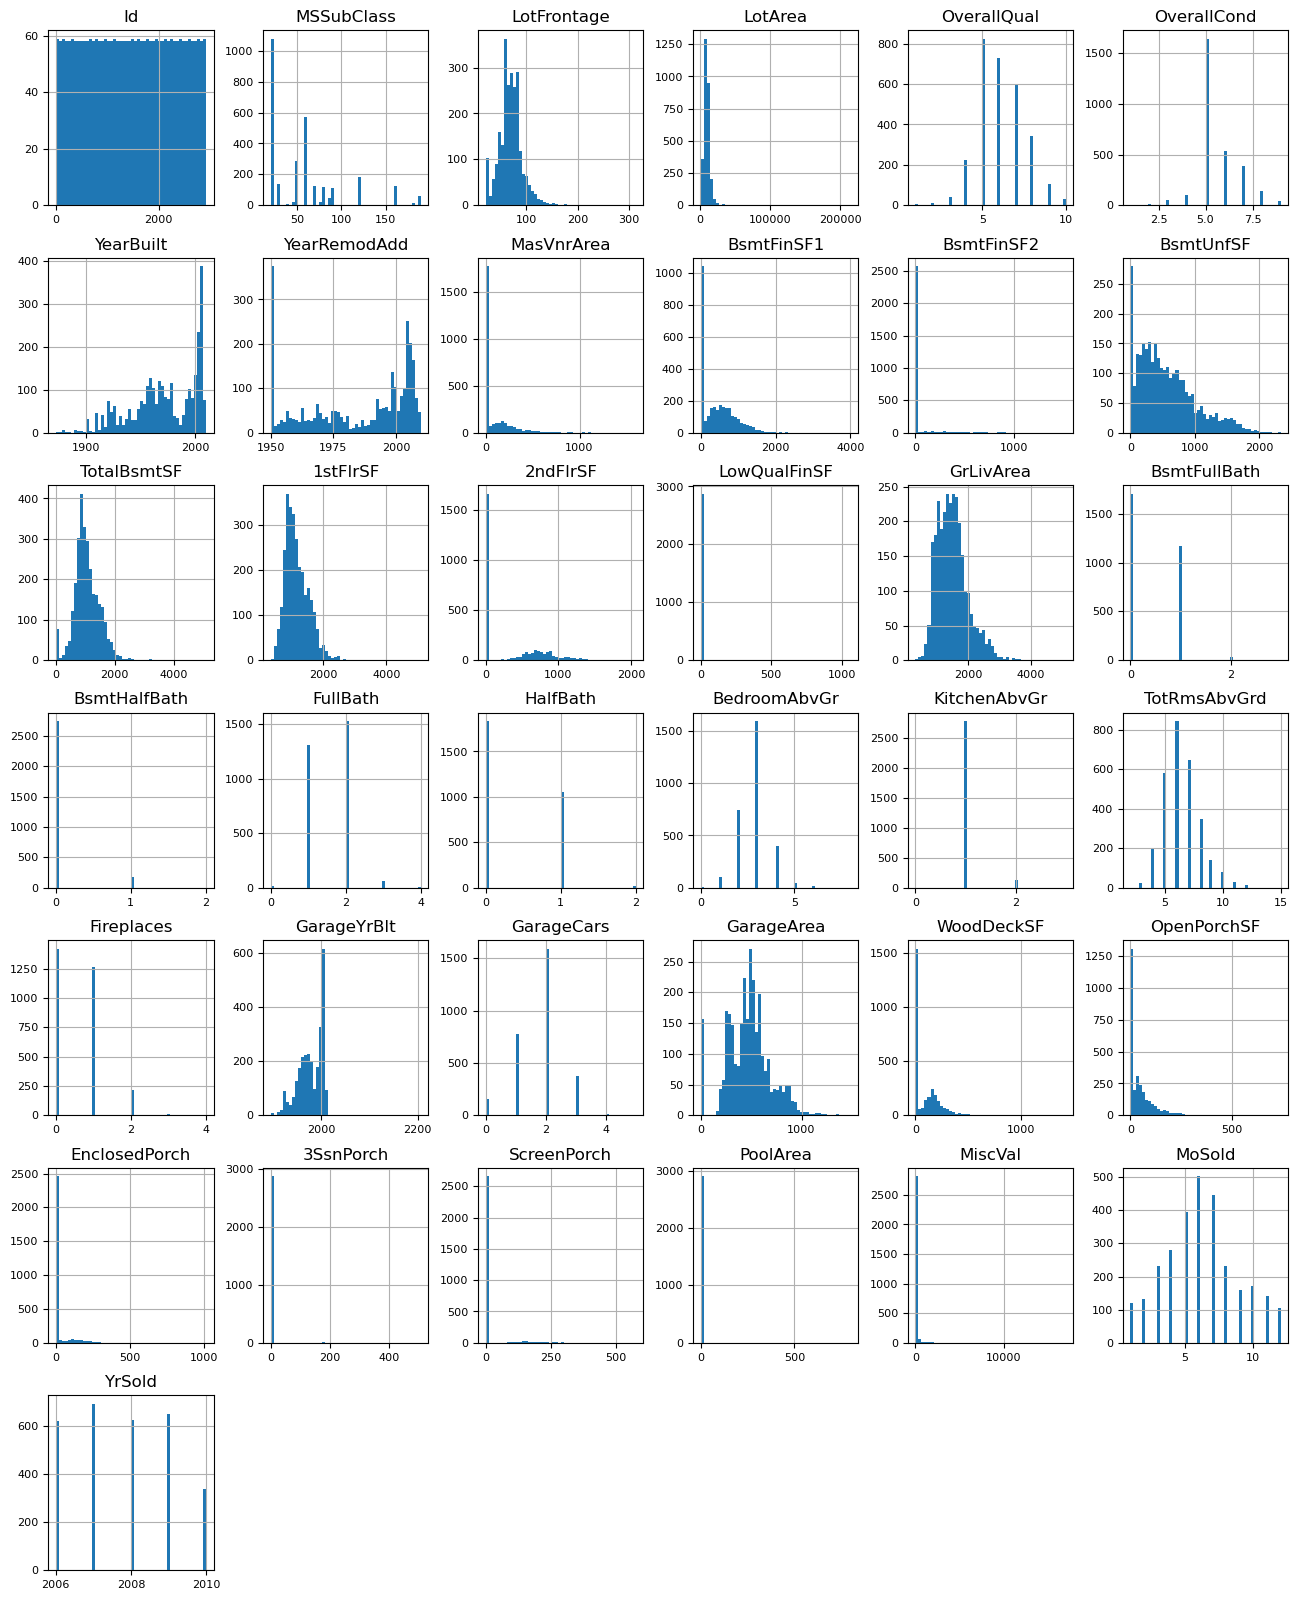

In [20]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8);

삭제할 수 있는 데이터가 꽤나 보이지만 일단 pass

## Prepare the dataset

This dataset contains a mix of numeric, categorical and missing features. TF-DF supports all these feature types natively, and no preprocessing is required. This is one advantage of tree-based models, making them a great entry point to Tensorflow and ML.

Now let us split the dataset into training and testing datasets:

현재 상황으로는 object 데이터도 있고 결측치 처리도 안한 상태
추가적인 데이터 전처리도 거의 없음!

In [21]:
for col in ('PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'MasVnrType', 'MSSubClass'):
    dataset_df[col] = dataset_df[col].fillna('None')

for col in ('GarageYrBlt', 'GarageArea', 'GarageCars', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'MasVnrArea','LotFrontage'):
    dataset_df[col] = dataset_df[col].fillna(0)
    
for col in ('MSZoning', 'Electrical', 'KitchenQual', 'Exterior1st', 'Exterior2nd', 'SaleType', 'Functional', 'Utilities'):
    dataset_df[col] = dataset_df[col].fillna(dataset_df[col].mode()[0])
    
print(f"Total count of missing values in dataset_df : {dataset_df.isnull().sum().sum()}")

Total count of missing values in dataset_df : 0


There's one more step required before we can train the model. We need to convert the datatset from Pandas format (`pd.DataFrame`) into TensorFlow Datasets format (`tf.data.Dataset`).

[TensorFlow Datasets](https://www.tensorflow.org/datasets/overview) is a high performance data loading library which is helpful when training neural networks with accelerators like GPUs and TPUs.

In [22]:
dataset_df=dataset_df.drop(columns=['Street','Utilities','Condition2','RoofMatl','Heating'])

<AxesSubplot:xlabel='PoolQC', ylabel='SalePrice'>

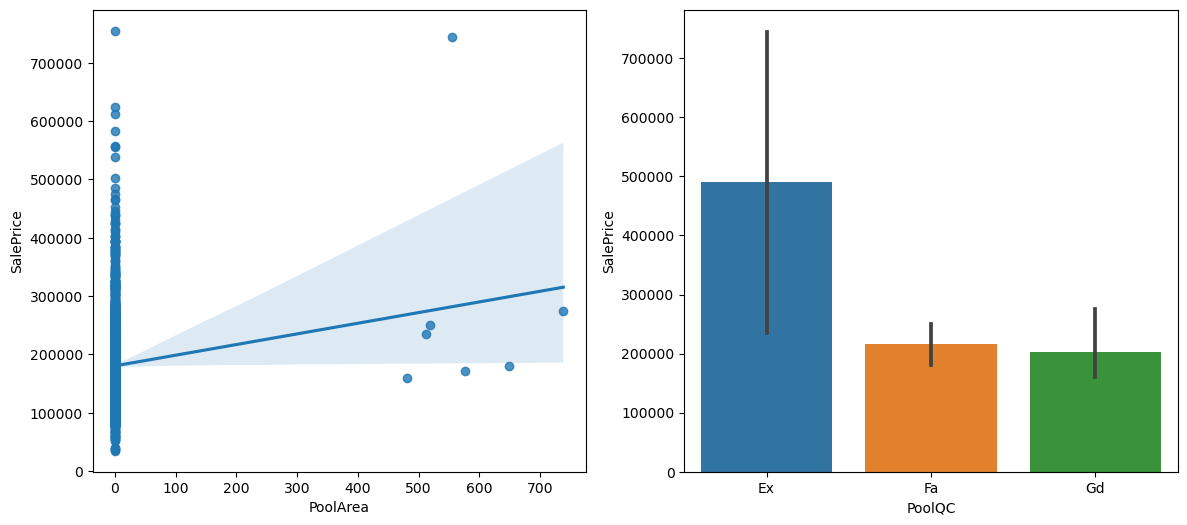

In [23]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=raw_data, x='PoolArea', y='SalePrice', ax=ax1)
sns.barplot(data=raw_data, x='PoolQC', y='SalePrice', ax=ax2)

In [24]:
dataset_df=dataset_df.drop(columns=['PoolArea','PoolQC'])

<AxesSubplot:xlabel='MiscFeature', ylabel='SalePrice'>

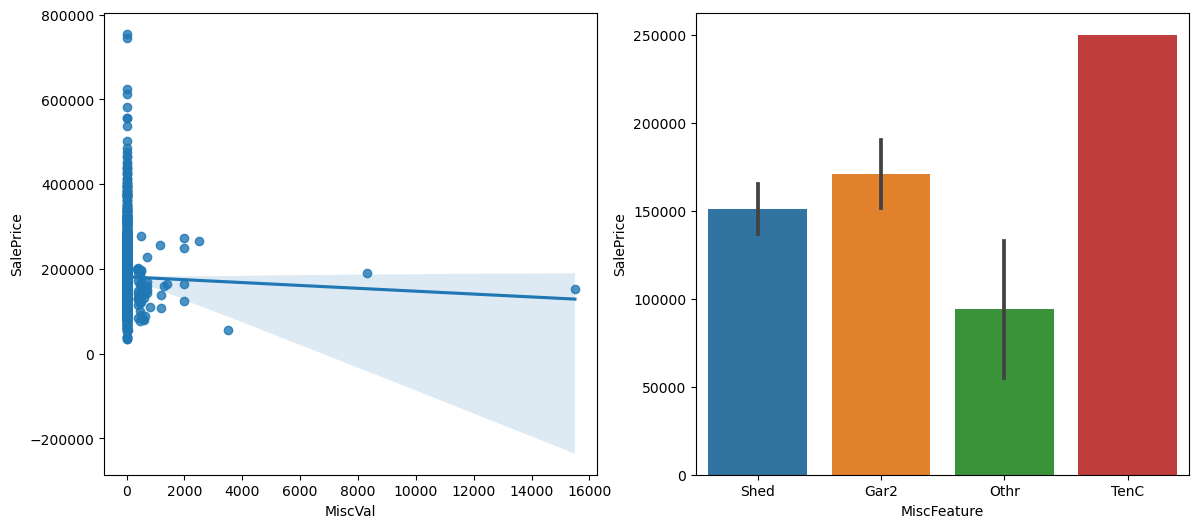

In [25]:
figure, (ax1, ax2) = plt.subplots(nrows=1, ncols=2)
figure.set_size_inches(14,6)
sns.regplot(data=raw_data, x='MiscVal', y='SalePrice', ax=ax1)
sns.barplot(data=raw_data, x='MiscFeature', y='SalePrice', ax=ax2)

In [26]:
dataset_df=dataset_df.drop(columns=['MiscVal','MiscFeature'])

In [27]:
# sns.regplot(data=raw_data, x='LowQualFinSF', y='SalePrice', ax=ax1)
# sns.regplot(data=raw_data, x='OpenPorchSF', y='SalePrice', ax=ax2)
# sns.regplot(data=raw_data, x='WoodDeckSF', y='SalePrice', ax=ax3)

In [28]:
dataset_df['NoLowQual']=(dataset_df['LowQualFinSF']==0)
dataset_df['NoOpenPorch']=(dataset_df['OpenPorchSF']==0)
dataset_df['NoWoodDeck']=(dataset_df['WoodDeckSF']==0)

By default the Random Forest Model is configured to train classification tasks. Since this is a regression problem, we will specify the type of the task (`tfdf.keras.Task.REGRESSION`) as a parameter here.

In [29]:
print(dataset_df.head())

   Id  MSSubClass MSZoning  LotFrontage  LotArea Alley LotShape LandContour  \
0   1          60       RL         65.0     8450  None      Reg         Lvl   
1   2          20       RL         80.0     9600  None      Reg         Lvl   
2   3          60       RL         68.0    11250  None      IR1         Lvl   
3   4          70       RL         60.0     9550  None      IR1         Lvl   
4   5          60       RL         84.0    14260  None      IR1         Lvl   

  LotConfig LandSlope  ... 3SsnPorch ScreenPorch Fence MoSold  YrSold  \
0    Inside       Gtl  ...         0           0  None      2    2008   
1       FR2       Gtl  ...         0           0  None      5    2007   
2    Inside       Gtl  ...         0           0  None      9    2008   
3    Corner       Gtl  ...         0           0  None      2    2006   
4       FR2       Gtl  ...         0           0  None     12    2008   

   SaleType  SaleCondition  NoLowQual NoOpenPorch NoWoodDeck  
0        WD         Nor

#dataset_df에 다시 원핫 인코딩을 진행한다.

In [30]:
non_numeric=dataset_df.select_dtypes(np.object)
print(non_numeric)

     MSZoning Alley LotShape LandContour LotConfig LandSlope Neighborhood  \
0          RL  None      Reg         Lvl    Inside       Gtl      CollgCr   
1          RL  None      Reg         Lvl       FR2       Gtl      Veenker   
2          RL  None      IR1         Lvl    Inside       Gtl      CollgCr   
3          RL  None      IR1         Lvl    Corner       Gtl      Crawfor   
4          RL  None      IR1         Lvl       FR2       Gtl      NoRidge   
...       ...   ...      ...         ...       ...       ...          ...   
1454       RM  None      Reg         Lvl    Inside       Gtl      MeadowV   
1455       RM  None      Reg         Lvl    Inside       Gtl      MeadowV   
1456       RL  None      Reg         Lvl    Inside       Gtl      Mitchel   
1457       RL  None      Reg         Lvl    Inside       Gtl      Mitchel   
1458       RL  None      Reg         Lvl    Inside       Mod      Mitchel   

     Condition1 BldgType HouseStyle  ... Functional FireplaceQu GarageType 

43 column으로 object column만 빠져나온걸 확인할 수 있다

In [31]:
def onehot(col_list):
    global dataset_df

    while len(col_list) !=0:
        col=col_list.pop(0)
        data_encoded=pd.get_dummies(dataset_df[col], prefix=col)
        data_encoded["Id"] = dataset_df["Id"]
        
        dataset_df=pd.merge(dataset_df, data_encoded, on='Id')
        dataset_df=dataset_df.drop(columns=col)
    print(dataset_df.shape)

    
onehot(list(non_numeric.columns))

(2917, 269)


In [32]:
print(dataset_df)

        Id  MSSubClass  LotFrontage  LotArea  OverallQual  OverallCond  \
0        1          60         65.0     8450            7            5   
1        2          20         80.0     9600            6            8   
2        3          60         68.0    11250            7            5   
3        4          70         60.0     9550            7            5   
4        5          60         84.0    14260            8            5   
...    ...         ...          ...      ...          ...          ...   
2912  2915         160         21.0     1936            4            7   
2913  2916         160         21.0     1894            4            5   
2914  2917          20        160.0    20000            5            7   
2915  2918          85         62.0    10441            5            5   
2916  2919          60         74.0     9627            7            5   

      YearBuilt  YearRemodAdd  MasVnrArea  BsmtFinSF1  ...  SaleType_ConLw  \
0          2003          2003    

In [33]:
# numeric=dataset_df.select_dtypes(np.number)

# def log_transform(col_list):
#     transformed_col=[]
#     while len(col_list)!=0:
#         col=col_list.pop(0)
#         if dataset_df[col].skew() > 0.5:
#             dataset_df[col]=np.log(dataset_df[col]+1)
#             transformed_col.append(col)
#         else:
#             pass
#     print(f"{len(transformed_col)} features had been transformed")
#     print(dataset_df.shape)

# log_transform(list(numeric))

## Select a Model

There are several tree-based models for you to choose from.

* RandomForestModel
* GradientBoostedTreesModel
* CartModel
* DistributedGradientBoostedTreesModel

To start, we'll work with a Random Forest. This is the most well-known of the Decision Forest training algorithms.

A Random Forest is a collection of decision trees, each trained independently on a random subset of the training dataset (sampled with replacement). The algorithm is unique in that it is robust to overfitting, and easy to use.

We can list the all the available models in TensorFlow Decision Forests using the following code:

In [34]:
dataset_df.pop('Id')

Xtrain = dataset_df[0:1458]

Xtest = dataset_df[1458:]

print(Xtrain.shape, Ytrain.shape)

(1458, 268) (1458,)


In [35]:
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from xgboost import XGBRegressor
import time
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

model_Lasso= make_pipeline(RobustScaler(), Lasso(alpha =0.000327, random_state=18))

model_ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.00052, l1_ratio=0.70654, random_state=18))

model_GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05, max_depth=4, max_features='sqrt', min_samples_leaf=15, 
                                         min_samples_split=10, loss='huber', random_state=18)

model_XGB=XGBRegressor(colsample_bylevel=0.9229733609038979,colsample_bynode=0.21481791874780318,colsample_bytree=0.607964318297635, 
                       gamma=0.8989889254961725, learning_rate=0.009192310189734834, max_depth=3, n_estimators=3602, 
                       reg_alpha=3.185674564163364e-12,reg_lambda=4.95553539265423e-13, seed=18, subsample=0.8381904293270576,
                       tree_method='hist',verbosity=0)

## How can I configure them?

TensorFlow Decision Forests provides good defaults for you (e.g. the top ranking hyperparameters on our benchmarks, slightly modified to run in reasonable time). If you would like to configure the learning algorithm, you will find many options you can explore to get the highest possible accuracy.

You can select a template and/or set parameters as follows:

```rf = tfdf.keras.RandomForestModel(hyperparameter_template="benchmark_rank1", task=tfdf.keras.Task.REGRESSION)```

Read more [here](https://www.tensorflow.org/decision_forests/api_docs/python/tfdf/keras/RandomForestModel).

## Create a Random Forest

Today, we will use the defaults to create the Random Forest Model while specifiyng the task type as `tfdf.keras.Task.REGRESSION`.

In [36]:
# non_numeric=Xtest.select_dtypes(np.object)
# print(non_numeric)

In [37]:
# print(len(Xtest))

In [38]:
# def onehot_t(col_list):
#     global Xtest

#     while len(col_list) !=0:
#         col=col_list.pop(0)
#         data_encoded=pd.get_dummies(Xtest[col], prefix=col)
#         data_encoded["Id"] = range(1,1460)
        
#         Xtest=pd.merge(Xtest, data_encoded, on='Id')
#         Xtest=Xtest.drop(columns=col)
#     print(Xtest.shape)

    
# onehot(list(non_numeric.columns))

In [39]:
submission = pd.read_csv('../input/house-prices-advanced-regression-techniques/sample_submission.csv')

In [40]:
model_Lasso.fit(Xtrain, Ytrain)
Lasso_predictions=model_Lasso.predict(Xtest)
train_Lasso=model_Lasso.predict(Xtrain)

model_ENet.fit(Xtrain, Ytrain)
ENet_predictions=model_ENet.predict(Xtest)
train_ENet=model_ENet.predict(Xtrain)

model_XGB.fit(Xtrain, Ytrain)
XGB_predictions=model_XGB.predict(Xtest)
train_XGB=model_XGB.predict(Xtrain)

model_GBoost.fit(Xtrain, Ytrain)
GBoost_predictions=model_GBoost.predict(Xtest)
train_GBoost=model_GBoost.predict(Xtrain)

# train_predictions = (train_Lasso + train_ENet + train_XGB + train_GBoost)/4
train_predictions = train_XGB
train_score=np.sqrt(mean_squared_error(Ytrain, train_predictions))
print(f"Scoring with train data : {train_score}")

# predictions=(Lasso_predictions + ENet_predictions + XGB_predictions + GBoost_predictions) / 4
log_predictions = XGB_predictions

predictions=np.exp(log_predictions)-1
submission['SalePrice']=predictions
# submission.to_csv('Result.csv')

Scoring with train data : 0.1259297315801277


네개의 모델로 train 예측 점수: 14259.051917841778

In [41]:
print(submission.head())

     Id      SalePrice
0  1461  125333.320312
1  1462  150144.515625
2  1463  179711.640625
3  1464  186273.078125
4  1465  188107.890625


In [42]:
submission.to_csv('/kaggle/working/submission.csv', index=False)

기본 예측 점수 : 0.14xxx <br>
네개의 모델로 평균내서 예측했을 때 점수 : 0.13717 <br>
XGBoost만으로 예측했을 때 점수: 0.12902 <br>
추가 전처리까지 해서 XGBoost로 예측했을 때 점수: 0.14979

## Train the model

We will train the model using a one-liner.

Note: you may see a warning about Autograph. You can safely ignore this, it will be fixed in the next release.

## Visualize the model
One benefit of tree-based models is that you can easily visualize them. The default number of trees used in the Random Forests is 300. We can select a tree to display below.

In [43]:
# tfdf.model_plotter.plot_model_in_colab(rf, tree_idx=0, max_depth=3)

## Evaluate the model on the Out of bag (OOB) data and the validation dataset

Before training the dataset we have manually seperated 20% of the dataset for validation named as `valid_ds`.

We can also use Out of bag (OOB) score to validate our RandomForestModel.
To train a Random Forest Model, a set of random samples from training set are choosen by the algorithm and the rest of the samples are used to finetune the model.The subset of data that is not chosen is known as Out of bag data (OOB).
OOB score is computed on the OOB data.

Read more about OOB data [here](https://developers.google.com/machine-learning/decision-forests/out-of-bag).

The training logs show the Root Mean Squared Error (RMSE) evaluated on the out-of-bag dataset according to the number of trees in the model. Let us plot this.

Note: Smaller values are better for this hyperparameter.

In [44]:
# import matplotlib.pyplot as plt
# logs = rf.make_inspector().training_logs()
# plt.plot([log.num_trees for log in logs], [log.evaluation.rmse for log in logs])
# plt.xlabel("Number of trees")
# plt.ylabel("RMSE (out-of-bag)")
# plt.show()

We can also see some general stats on the OOB dataset:

In [45]:
# inspector = rf.make_inspector()
# inspector.evaluation()

Now, let us run an evaluation using the validation dataset.

In [46]:
# evaluation = rf.evaluate(x=valid_ds,return_dict=True)

# for name, value in evaluation.items():
#   print(f"{name}: {value:.4f}")

## Variable importances

Variable importances generally indicate how much a feature contributes to the model predictions or quality. There are several ways to identify important features using TensorFlow Decision Forests.
Let us list the available `Variable Importances` for Decision Trees:

In [47]:
# print(f"Available variable importances:")
# for importance in inspector.variable_importances().keys():
#   print("\t", importance)

As an example, let us display the important features for the Variable Importance `NUM_AS_ROOT`.

The larger the importance score for `NUM_AS_ROOT`, the more impact it has on the outcome of the model.

By default, the list is sorted from the most important to the least. From the output you can infer that the feature at the top of the list is used as the root node in most number of trees in the random forest than any other feature.

In [48]:
# inspector.variable_importances()["NUM_AS_ROOT"]

Plot the variable importances from the inspector using Matplotlib

# Submission
Finally predict on the competition test data using the model.